# MCMC Analysis and Plots
This notebook is to analyze MCMC walk data and produce relevant results plots

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [3]:
#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def LindFit_helper(theta):
    return calc_log_prob(model='Lind', theta=theta, theta_bounds=((0,1),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

def ChavFit_helper(theta):
    return calc_log_prob(model='Chav', theta=theta, theta_bounds=((0,1),(1/10e3,1/0.1),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

def SorFit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

In [37]:
#Load the MCMC data
import pickle as pkl

#Set these to the correct filename and yield type
#fname='data/mcmc_Lind_8walk_5000step_pois_v5.pkl'
#model='Lind'

#fname='data/mcmc_Chav_16walk_5000step_pois_v2.pkl'
#model='Chav'

fname='data/mcmc_Sor_16walk_5000step_pois_v9.pkl'
model='Sor'

############################
basename=os.path.splitext(os.path.basename(fname))[0]

results=pkl.load(open(fname,'rb'))
sampler=results['sampler']
guesses=results['guesses']
labels=results['labels']

/home/mast/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:17: ResourceWarning: unclosed file <_io.BufferedReader name='data/mcmc_Sor_16walk_5000step_pois_v9.pkl'>


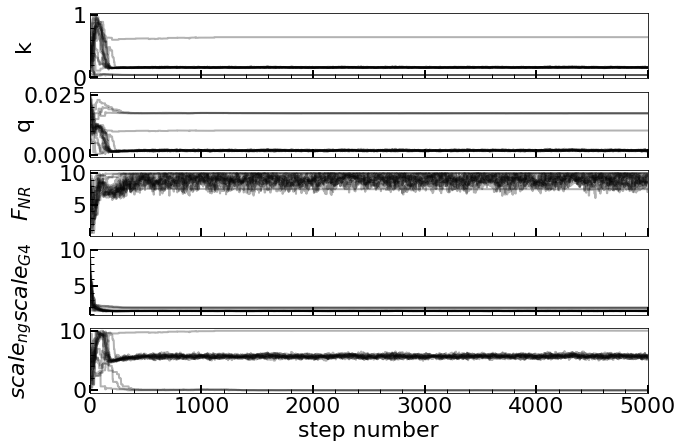

In [38]:
#Look at the chain of parameter values
#labels_l = [r'k', r'sim scale', r'$F_{NR}$']
#labels_c = [r'k', r'$a^{-1}$', r'sim scale', r'$F_{NR}$']
#labels_s = [r'k', r'q', r'sim scale', r'$F_{NR}$']

#if model=='Lind':
#    labels=labels_l
#elif model=='Chav':
#    labels=labels_c
#elif model=='Sor':
#    labels=labels_s



samples = sampler.get_chain()
ndim = samples.shape[2]

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

plt.savefig('figures/mcmc/'+basename+'_chains.png')

In [39]:
sampler.acceptance_fraction

array([0.3864, 0.3902, 0.369 , 0.0464, 0.3934, 0.0162, 0.3708, 0.3796,
       0.0616, 0.4082, 0.372 , 0.3726, 0.3824, 0.3948, 0.083 , 0.3784])

In [40]:
#Get the sample autocorrelation times for each variable and use the largest one
tau=sampler.get_autocorr_time()
print(tau)
avgtau=round(np.max(tau))
print(avgtau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [ 94.62360666  95.39750951 139.84882519  54.69422324 102.40770065]

In [41]:
#Manually impose a value for short chains
avgtau=150
#avgtau=200

#Discard a few times tau as burn-in and thin by tau/2
flat_samples = sampler.get_chain(discard=int(2.*avgtau), thin=int(round(avgtau/2.)), flat=True)
print(flat_samples.shape)

(992, 5)


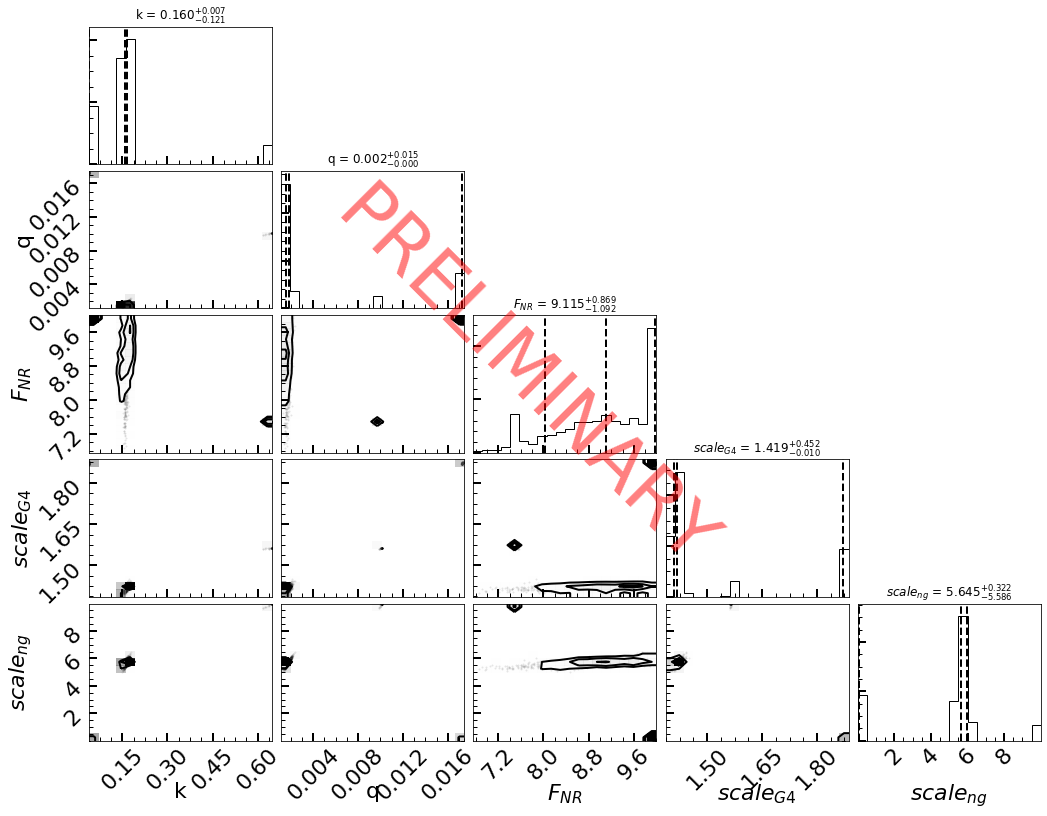

In [42]:
#Make the corner plot
import corner

fig_w=15
fig,ax = plt.subplots(ndim,ndim,figsize=(fig_w, fig_w*(.75)))

fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f', fig=fig
);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
plt.savefig('figures/mcmc/'+basename+'_corner.png')

In [43]:
#Calculate the median and 1-sigma equivalent uncertainties
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    txt=txt.replace('$','')
    #print(txt)
    display(Math(txt))

<>:7: DeprecationWarning: invalid escape sequence \m
<>:7: DeprecationWarning: invalid escape sequence \m
<>:7: DeprecationWarning: invalid escape sequence \m
<ipython-input-43-d6789aa4ec88>:7: DeprecationWarning: invalid escape sequence \m
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [44]:
#Get the best fit results
theta=np.zeros(ndim)
for i in range(ndim):
    theta[i]=np.percentile(flat_samples[:, i], 50)
print(theta)

[1.60252427e-01 1.81944253e-03 9.11483297e+00 1.41879246e+00
 5.64508420e+00]


# Show best fit spectrum

In [12]:
#Load the data
import R68_load as r68

meas=r68.load_measured()
g4=r68.load_G4(load_frac=0.1)
cap=r68.load_simcap(file='/data/chocula/villaa/cascadeSimData/si28_R68_400k.pkl', rcapture=0.161, load_frac=0.1)

Loading Measured Data...
(480634,)
(174510,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
3.7  min
Loading ERs...
1.1  min
Loading (n,gamma) Data...
400000


In [45]:
#Energy binning
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)

Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

#Changed on 14 Feb 2020 for speed
#Emax = 1000 #eVee 
#Ebins=np.linspace(0,Emax,101)
#Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

############
##Playing around
##COMMENT OUT
############
cal_scale=1

#Measured spectra
N_meas_PuBe,_ = np.histogram(cal_scale*meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(cal_scale*meas['Bkg']['E'],bins=Ebins)


R_meas = N_meas_PuBe/meas['PuBe']['tlive']-N_meas_Bkg/meas['Bkg']['tlive']
dR_meas = np.sqrt( N_meas_PuBe/(meas['PuBe']['tlive']**2) + N_meas_Bkg/(meas['Bkg']['tlive']**2) )

In [46]:
import R68_spec_tools as spec
import R68_yield as Yield
Y=Yield.Yield('Lind',[0.2])

if model=='Lind':
    nYpar=1
elif (model=='Chav' or model=='Sor'):
    nYpar=2
elif (model=='Damic'):
    nYpar=0
else:
    print('Error: Yield model not defined.')

Y.model=model
Y.pars=theta[:nYpar]
F_NR=theta[nYpar]
scale_g4=theta[nYpar+1]
scale_ng=theta[nYpar+2]
    
#######################
#Playing around
#COMMENT OUT
#######################

#Y=Yield.Yield('Damic',[])
#Slow, just use this
#Y=Yield.Yield('Chav',[0.146,1/(0.247e-3)])
#F_NR=1
#scale_g4*=0.75
#scale_ng*=1

#Y=Yield.Yield('Chav',[0.12,800])
#F_NR=0.3
#scale_g4*=1
#scale_ng*=2

#cutoff=100 #eV_NR
#q=11.5*14**(-7./3)*cutoff*1e-3
#Y=Yield.Yield('Sor',[0.17,q])
#F_NR=1
#scale_g4*=1.2
#scale_ng*=2.8

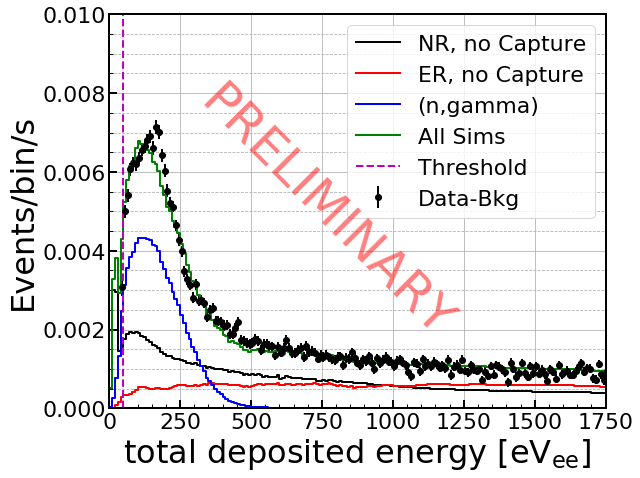

In [48]:
plotBest=True #Plot just the best fit spectrum


if plotBest:
    NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, fpeak=1)
    spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'],
                     N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas,
                     xrange=(0,1.75e3), yrange=(0,1e-2), thresh=Ebins[np.digitize(50,Ebins)-1])
else:
    fig,ax=plt.subplots(figsize=(8,6))

    #Plot a subset of spectra at some chain values
    Y.model=model
    inds = np.random.randint(len(flat_samples), size=100)
    for ind in inds:
        thetai = flat_samples[ind]
        if model=='Lind':
            Y.pars=thetai[:1]
        elif (model=='Chav' or model=='Sor'):
            Y.pars=thetai[:2]
        elif (model=='Damic'):
            Y.pars=[]
        
        NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                            Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, fpeak=1)
        spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'],
                         N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas,
                         xrange=(0,1.75e3), yrange=(0,1e-2), thresh=Ebins[np.digitize(50,Ebins)-1],axis=ax, wLeg=False)


plt.gcf().text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5)

plt.savefig('figures/mcmc/'+basename+'_spectrum.png')

# Yield curve

In [49]:
from scipy.optimize import fsolve
def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

Text(0.3, 0.3, 'PRELIMINARY')

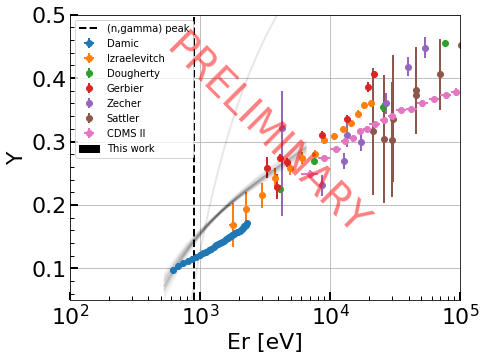

In [50]:
import R68_plot_tools as pt
import matplotlib.patches as mpatches

#Plot best fit yield (comment out to use Y from above)
#Y=Yield.Yield('Lind',[0.2])
#Y.pars=theta[:1]

thresh_low_NR=ERtoNR(50,Y,V,eps)
thresh_high_NR=ERtoNR(2000,Y,V,eps)

fig_w=7
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))


#TODO: Determine this range
Er_plot=np.linspace(thresh_low_NR,thresh_high_NR,100)

#Add other measurements from lit
pt.plotOldYs(ax,fmt='o')

#TEST
#ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=1, linewidth=5)

#This work
Y.model=model
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    #thetai = flat_samples[ind][0]
    #Y=Yield.Yield('Lind',[thetai])
    #ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)
    
    thetai = flat_samples[ind]
    if model=='Lind':
        Y.pars=thetai[:1]
    elif (model=='Chav' or model=='Sor'):
        Y.pars=thetai[:2]
    elif (model=='Damic'):
        Y.pars=[]
    ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)


ax.axvline(ERtoNR(150,Y,V,eps), color='k', linestyle='--', label='(n,gamma) peak')
    
#ax.axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#ax.axvline(thresh_high_NR, color='m', linestyle='--')

#Example Lindhard curves
#Er_full=np.logspace(2,5,100)
#Y=Yield.Yield('Lind',[0.146])
#ax.plot(Er_full, Y.calc(Er_full), '--k')
#Y=Yield.Yield('Chav',[0.15,0.247])
#ax.plot(Er_full, Y.calc(Er_full), '--k')

#Manually add legend entry
handles, labels = ax.get_legend_handles_labels()
patch = mpatches.Patch(color='k', label='This work')
handles.append(patch) 

ax.legend(handles=handles, loc='upper left')

ax.set_xscale('log')
ax.set_xlabel('Er [eV]')
ax.set_ylabel('Y')
ax.set_xlim(1e2,1e5);
ax.set_ylim(0.05,0.5);
ax.grid()

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield_compare.png')

How to determine the range over which we trust this yield? Let's also histogram all the Ers at which we evaluated the yield, so  we can see how densely we probed it.

In [ ]:
#Direct NRs
evec_nr=g4['NR']['E']
evec_Nnr=g4['NR']['N']

#Select events which end up in the analysis ROI
Eee_nr = np.sum(evec_nr*(1 + Y.calc(evec_nr)*V/eps)/(1+V/eps),1)
evec_nr=evec_nr[(Eee_nr>50) & (Eee_nr<1000)]
evec_Nnr=evec_Nnr[(Eee_nr>50) & (Eee_nr<1000)]

#Separate out singles and multiples
evec_nr_sing=evec_nr[(evec_Nnr==1).flatten()]
evec_nr_mult=evec_nr[(evec_Nnr!=1).flatten()]

#Flatten and remove 0's
evec_nr_sing=evec_nr_sing[evec_nr_sing!=0].flatten()
evec_nr_mult=evec_nr_mult[evec_nr_mult!=0].flatten()

In [ ]:
#(n,gamma)
evec_ng=cap['E']
devec_ng=cap['dE']
evec_Nng=cap['N']

#Select events which end up in the analysis ROI
evec_ng_eion = evec_ng*Y.calc(evec_ng) - (evec_ng-devec_ng)*Y.calc(evec_ng-devec_ng)
Eee_ng = np.sum((devec_ng + evec_ng_eion*V/eps)/(1+V/eps),1)
evec_ng=evec_ng[(Eee_ng>50) & (Eee_ng<2000)]
devec_ng=devec_ng[(Eee_ng>50) & (Eee_ng<2000)]
evec_Nng=evec_Nng[(Eee_ng>50) & (Eee_ng<2000)]

#Separate out singles and multiples
evec_ng_sing=evec_ng[(evec_Nng==1).flatten()]
evec_ng_mult=evec_ng[(evec_Nng!=1).flatten()]
#Flatten and remove 0's
evec_ng_sing=evec_ng_sing[evec_ng_sing!=0].flatten()
evec_ng_mult=evec_ng_mult[evec_ng_mult!=0].flatten()

In [ ]:
#Make histograms
Emax_Er = 3500 #eVee
Ebins_Er=np.linspace(0,Emax_Er,101)
Ebins_Er_ctr=(Ebins_Er[:-1]+Ebins_Er[1:])/2

n_nr_sing,_=np.histogram(evec_nr_sing, bins=Ebins_Er)
n_nr_mult,_=np.histogram(evec_nr_mult, bins=Ebins_Er)

n_ng_sing,_=np.histogram(evec_ng_sing, bins=Ebins_Er)
n_ng_mult,_=np.histogram(evec_ng_mult, bins=Ebins_Er)

#Adjust for relative livetime
n_nr_sing=n_nr_sing/g4['NR']['tlive']
n_nr_mult=n_nr_mult/g4['NR']['tlive']
n_ng_sing=n_ng_sing/cap['tlive']
n_ng_mult=n_ng_mult/cap['tlive']

#Normalize
n_tot=np.sum(n_nr_sing+n_nr_mult+n_ng_sing+n_ng_mult)
n_nr_sing/=n_tot
n_nr_mult/=n_tot
n_ng_sing/=n_tot
n_ng_mult/=n_tot

In [ ]:
#Draw stacked histogram

fig_w=7
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

#No relative livetime
#ax.hist([evec_nr_mult, evec_nr_sing, evec_ng_mult, evec_ng_sing], bins=Ebins_Er, stacked=True, density= True, 
#        label=['NR Multiples', 'NR Singles', '(n,gamma) multiples', '(n,g) singles'])

#Relative livetimes, but no shading
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing+n_ng_mult+n_ng_sing, where='mid', linestyle='-', \
#        label='(n,gamma) Singles', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing+n_ng_mult, where='mid', linestyle='-', \
#        label='(n,gamma) Multiples', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing, where='mid', linestyle='-', \
#        label='NR Singles', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult, where='mid', linestyle='-', \
#             label='NR Multiples', linewidth=2)


ax.fill_between(Ebins_Er_ctr,n_nr_mult, step='mid', \
             label='NR Multiples', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_nr_sing+n_nr_mult, n_nr_mult, step='mid', \
             label='NR Singles', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_ng_mult+n_nr_sing+n_nr_mult, n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Multiples', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult+n_nr_sing+n_nr_mult,n_ng_mult+n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Singles', linewidth=2)


ax.axvline(ERtoNR(50,Y,V,eps), color='m', linestyle='--', label='Analysis range')
#ax.axvline(ERtoNR(2000,Y,V,eps), color='m', linestyle='--')

ax.set_yscale('log')
ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Fraction of Hits')
ax.set_ylim(1e-3,2e-1)
ax.legend()

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

plt.tight_layout()
#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_hits.png')

In [ ]:
# Just our curve
fig,axs = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

Er_plot=np.linspace(10,3.5e3,100)

Y.model=model
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    #thetai = flat_samples[ind][0]
    #Y=Yield.Yield('Lind',[thetai])
    #ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)
    
    thetai = flat_samples[ind]
    if model=='Lind':
        Y.pars=thetai[:1]
    elif (model=='Chav' or model=='Sor'):
        Y.pars=thetai[:2]
    elif (model=='Damic'):
        Y.pars=[]
    axs.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)
    
    
axs.set_xlabel(r'$E_{recoil}$ [eV]')
axs.set_ylabel('Y')

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

plt.tight_layout()
#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield.png')

In [ ]:
# Combine both plots
fig,axs = plt.subplots(2,1,figsize=(fig_w, 1.5*fig_w*(.75)), sharex=True)

#TODO: Add other measurements from lit
#pt.plotOldYs(axs[0],fmt='.')

#This work
Er_plot=np.linspace(10,3.5e3,100)
Y.model=model
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    #thetai = flat_samples[ind][0]
    #Y=Yield.Yield('Lind',[thetai])
    #ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)
    
    thetai = flat_samples[ind]
    if model=='Lind':
        Y.pars=thetai[:1]
    elif (model=='Chav' or model=='Sor'):
        Y.pars=thetai[:2]
    elif (model=='Damic'):
        Y.pars=[]
    axs[0].plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)

#axs[0].axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#axs[0].axvline(thresh_high_NR, color='m', linestyle='--')

#axs[0].set_xlabel('Er [eV]')
axs[0].set_ylabel('Y')
#axs[0].set_yscale('log')
#axs[0].set_xscale('log')
#ax.set_ylim(0.1,0.3);

#Manually add legend entry
import matplotlib.patches as mpatches
handles, labels = axs[0].get_legend_handles_labels()
patch = mpatches.Patch(color='k', label='This work')
handles.append(patch) 

axs[0].legend(handles=handles, loc='upper left')


fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=45, alpha=0.5)


axs[1].fill_between(Ebins_Er_ctr,n_nr_mult, step='mid', \
             label='NR Multiples', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_nr_sing+n_nr_mult, n_nr_mult, step='mid', \
             label='NR Singles', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_ng_mult+n_nr_sing+n_nr_mult, n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Multiples', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult+n_nr_sing+n_nr_mult,n_ng_mult+n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Singles', linewidth=2)


#ax.axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#ax.axvline(thresh_high_NR, color='m', linestyle='--')

axs[1].set_yscale('log')
axs[1].set_xlabel(r'Hit $E_{recoil}$ [eV]')
axs[1].set_ylabel('Fraction of Hits')
#axs[1].set_xlim(0,5e3)
axs[1].set_ylim(1e-3,2e-1)
axs[1].legend()
plt.tight_layout()

#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield_and_hist.png')

In [ ]:
#Combined spectrum plot with hits histogram
if model=='Lind':
    nYpar=1
elif (model=='Chav' or model=='Sor'):
    nYpar=2
elif (model=='Damic'):
    nYpar=0
else:
    print('Error: Yield model not defined.')

Y.model=model
Y.pars=theta[:nYpar]
F_NR=theta[nYpar]
scale_g4=theta[nYpar+1]
scale_ng=theta[nYpar+2]

NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True)

In [ ]:
#fig,axs = plt.subplots(2,1,figsize=(fig_w, 1.5*fig_w*(.75)))

fig = plt.figure(figsize=(fig_w, 1.5*fig_w*(.75)))
gs = fig.add_gridspec(16, 1)
ax0 = fig.add_subplot(gs[:4, :])
ax1 = fig.add_subplot(gs[6:, :])
axs=[ax0,ax1]

#Spectra
spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'], 
                 N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas , 
                 yrange=(0,1e-2), thresh=Ebins[5], axis=axs[1])

axs[1].set_yticks(np.array([0, 4e-3, 8e-3]))
axs[1].set_xlabel('total deposited energy [eV$_{\\mathrm{ee}}$]',{'size':'22'})
axs[1].set_ylabel('Events/bin/s',{'size':'22'})
axs[1].legend(loc=1,prop={'size':14})

#Second NR axis for spectra
#Use Y defined in previous cell
#Y=Yield.Yield('Lind',pars[:1])

#axs_nr = axs[1].twiny()
#nr_ticks = np.array([0,1e3,2e3,3e3])

#axs_nr.set_xlim(axs[1].get_xlim())
#axs_nr.set_xticks(NRtoER(nr_ticks,Y,V,eps))
#axs_nr.set_xticklabels(nr_ticks.astype(int))

#axs_nr.set_xlabel(r"Modified x-axis: $1/(1+X)$")


#Hit histos
axs[0].fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult, step='mid', \
             label='(n,gamma) hits', linewidth=2)

axs[0].axvline(ERtoNR(Ebins[5],Y,V,eps), color='m', linestyle='--', linewidth=2, label='Single Hit Threshold')

axs[0].set_xlabel(r'Hit $E_{recoil}$ [eV]')
#axs[0].set_xlim(0,ERtoNR(axs[1].get_xlim()[1],Y,V,eps))
axs[0].set_xlim(0,1000)

axs[0].set_yscale('log')
axs[0].set_ylabel('Fraction\nof Hits')
axs[0].set_ylim(1e-4,2e0)
axs[0].set_yticks([1e-4,1e0])
axs[0].legend()

#Connect the axis ranges with some lines like a zoom-in
transFigure = fig.transFigure.inverted()

coord_a0 = transFigure.transform(axs[0].transData.transform([0,1e-4]))
coord_a1 = transFigure.transform(axs[1].transData.transform([0,1e-2]))
coord_b0 = transFigure.transform(axs[0].transData.transform([1e3,1e-4]))
coord_b1 = transFigure.transform(axs[1].transData.transform([NRtoER(1e3,Y,V,eps),1e-2]))


line_a = mpl.lines.Line2D((coord_a0[0],coord_a1[0]),(coord_a0[1],coord_a1[1]),
                          transform=fig.transFigure, color='k', linewidth=1)
line_b = mpl.lines.Line2D((coord_b0[0],coord_b1[0]),(coord_b0[1],coord_b1[1]),
                          transform=fig.transFigure, color='k', linewidth=1)
fig.lines.extend([line_a,line_b])

coords=np.array([coord_a0, coord_a1, coord_b1, coord_b0,])
poly = mpl.patches.Polygon(coords,fill=True, color='k', alpha=0.2, zorder=0,
                                  transform=fig.transFigure, figure=fig)
fig.patches.extend([poly])

axs[1].add_patch(plt.Rectangle((0,0), NRtoER(1e3,Y,V,eps), 1e-2,
                     facecolor='k', alpha=0.2))

fig.text(0.2, 0.2, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5);

plt.tight_layout()

#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_spectrum_hits_comp.png', bbox_inches = "tight")

In [ ]:
#Anthony want's to know how much of the (n,gamma) signal ends up above threshold

#cap['E']*Y.calc(evec_ng) - (cap['E']-cap['dE'])*Y.calc(cap['E']-cap['dE'])
#np.sum((devec_ng + evec_ng_eion*V/eps)/(1+V/eps),1)

plt.hist(Eee_ng,bins=np.linspace(0,500,100),label='(n,gamma)');
plt.axvline(50,color='m', linestyle='--',label='threshold')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r'$E_{Recoil}~[eVee]$')

plt.legend()

sums,_=np.histogram(Eee_ng,bins=[0,50,5000])

print(len(Eee_ng),sums,np.sum(sums),sums/np.sum(sums))